In [1]:
# !/usr/bin/env python
# coding: utf-8

import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)
from EDA_functions import *
seed = 5000

# 0. CARGA DE DATOS.

In [2]:
path='../outputs/'
df = get_data(name_sav='df_application_final_new.sav',
              path=path)

__NOTA:__ Se hará uso de algunas funciones contenidas en el script __EDA_functions.py__.

# 1. TAMAÑO DE DATA - CONTRUCCIONES PRELIMINARES.

Veamos cuál es el tamaño de data.

In [3]:
df.shape

(4990, 19)

In [4]:
df.head(2)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,STATUS
0,5009628,F,N,N,0,238500.0,Working,Secondary / secondary special,Married,House / apartment,-19305,-3296,1,1,0,0,Laborers,2.0,1
1,5009746,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557,-586,1,1,1,0,NaN,2.0,1


Recordemos la configuración de la variable objetivo `STATUS`.

In [5]:
print('FRECUENCIA:')
print(df['STATUS'].value_counts())
print('FRECUENCIA RELATIVA:')
print(round((df['STATUS'].value_counts(normalize=True)) * 100), 2)

FRECUENCIA:
0    4491
1     499
Name: STATUS, dtype: int64
FRECUENCIA RELATIVA:
0    90.0
1    10.0
Name: STATUS, dtype: float64 2


Se obtiene las variables de __Edad__ y __Años laborando__.

In [6]:
df["AGE"] = - df['DAYS_BIRTH'] / 365
df["AGE"] = df["AGE"].astype(int)
df['WORK_YEARS'] = -df['DAYS_EMPLOYED'] / 365
df["WORK_YEARS"] = df["WORK_YEARS"].astype(int)

Veamos qué variables poseen valores perdidos y los porcentajes de missing.

In [7]:
count_missing = get_count_missing(data=df,
                                  feature_names=list(df.columns))
count_missing

,name,conteo,porcentaje
0,OCCUPATION_TYPE,1494,29.94
1,ID,0,0.00
2,DAYS_EMPLOYED,0,0.00
3,AGE,0,0.00
4,STATUS,0,0.00
5,CNT_FAM_MEMBERS,0,0.00
6,FLAG_EMAIL,0,0.00
7,FLAG_PHONE,0,0.00
8,FLAG_WORK_PHONE,0,0.00
9,FLAG_MOBIL,0,0.00


La única variable con missing es una variable categórica llamada `OCCUPATION_TYPE`. Se haŕá el debido tratamiento en su momento.

# 2. TRATAMIENTO DE VARIABLES NUMÉRICAS.

## 2.1 Visualización y Control de outliers.

Se identifican las variables numéricas.

In [8]:
num_names = list(df.select_dtypes(include=['float64', 'int64']).columns)
num_names

['ID',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'FLAG_MOBIL',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'STATUS',
 'AGE',
 'WORK_YEARS']

Observamos que:
* La 'ID' es una varibale de identificación.
* 'STATUS' es la variable objetivo.
* 'DAYS_BIRTH' y 'DAYS_EMPLOYED' ya han sido tranformadas.
* 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL' son en realidad variables de naturaliza binaria. 

Siendo así no se considerarán como numéricas.

In [9]:
no_numeric = ['ID',
             'STATUS',
             'DAYS_BIRTH',
             'DAYS_EMPLOYED',
             'FLAG_MOBIL',
             'FLAG_WORK_PHONE',
             'FLAG_PHONE',
             'FLAG_EMAIL']

In [10]:
num_names = list(set(num_names)-set(no_numeric))
num_names

['WORK_YEARS', 'CNT_FAM_MEMBERS', 'AMT_INCOME_TOTAL', 'CNT_CHILDREN', 'AGE']

Al contar con un número no tan grande de variables numéricas, es posible una exploración individual de la distribuciones usando histogramas y box-plots.

In [11]:
for name in num_names:
    print(f'################################## VARIABLE: {name} ################################################')
    fig = px.histogram(df,
                       x=name,
                       nbins=50,
                       marginal='box')
    fig.show()

################################## VARIABLE: WORK_YEARS ################################################


################################## VARIABLE: CNT_FAM_MEMBERS ################################################


################################## VARIABLE: AMT_INCOME_TOTAL ################################################


################################## VARIABLE: CNT_CHILDREN ################################################


################################## VARIABLE: AGE ################################################


Pasa una situación para la variable `WORK_YEARS`. Las personas desempleadas tienen por default un valor de -1000, por lo que para observar la verdadera distribución de la variable, se deben de considerar valores arriba de cero.

In [12]:
df[df['WORK_YEARS'] <0]['WORK_YEARS'].unique()

array([-1000])

In [13]:
fig = px.histogram(df[df['WORK_YEARS'] >=0],
                   x='WORK_YEARS',
                   nbins=50,
                   marginal='box')
fig.show()

Podemos observar lo siguiente:

* Algunas variables como 'WORK_YEARS' y 'AMT_INCOME_TOTAL' están sesgadas a la derecha. Por ahora no se hará ningúna tranformación para centralizar estas distribuciones.
* Las variables 'AMT_INCOME_TOTAL', 'CNT_FAM_MEMBERS', 'CNT_CHILDREN' cuentan con claros outliers, es decir, puntos que se alejan no solo de la concentración de la información, sino de la cola natural de la distribución. Estos valores son extremos (valores positivos muy grandes).

Para ejercer cierto control de outliers en variables sesgadas a la derecha, se impondrán cotas superiores a las variables involucradas

In [14]:
df_OUTLIERS = df[(df['AMT_INCOME_TOTAL'] <= 800000)
                 & (df['CNT_FAM_MEMBERS'] <= 8) 
                 & (df['CNT_CHILDREN'] <= 6)]

In [15]:
df_OUTLIERS

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,STATUS,AGE,WORK_YEARS
0,5009628,F,N,N,0,238500.0,Working,Secondary / secondary special,Married,House / apartment,...,-3296,1,1,0,0,Laborers,2.0,1,52,9
1,5009746,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,...,-586,1,1,1,0,NaN,2.0,1,37,1
2,5009938,F,N,Y,2,157500.0,Working,Secondary / secondary special,Married,House / apartment,...,-2351,1,0,0,0,Sales staff,4.0,1,29,6
3,5010061,F,N,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,-4574,1,0,0,0,NaN,2.0,1,45,12
4,5010535,F,Y,N,2,135000.0,Working,Secondary / secondary special,Married,House / apartment,...,-3052,1,0,0,0,Laborers,4.0,1,38,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4985,5139370,F,N,Y,0,121500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,...,-8163,1,0,0,0,High skill tech staff,2.0,0,50,22
4986,5066551,F,N,Y,0,135000.0,Pensioner,Higher education,Married,House / apartment,...,365243,1,0,1,1,NaN,2.0,0,64,-1000
4987,5036785,M,N,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,-219,1,0,1,0,HR staff,2.0,0,43,0
4988,5088266,F,N,Y,0,270000.0,Working,Secondary / secondary special,Married,House / apartment,...,-6678,1,0,0,0,NaN,2.0,0,45,18


Se comparam las distribuciones de la variable indicada antes y después de outliers.

In [16]:
skew_num_names = ['AMT_INCOME_TOTAL', 'CNT_FAM_MEMBERS', 'CNT_CHILDREN']
for name in skew_num_names:
    print(f'################################## VARIABLE: {name} ################################################')
    print(f'Antes de outliers.')
    fig = px.histogram(df,
                       x=name,
                       nbins=50,
                       marginal='box')
    fig.show()
    print(f'Después de outliers.')
    fig2 = px.histogram(df_OUTLIERS,
                        x=name,
                        nbins=50,
                        marginal='box')
    fig2.show()

################################## VARIABLE: AMT_INCOME_TOTAL ################################################
Antes de outliers.


Después de outliers.


################################## VARIABLE: CNT_FAM_MEMBERS ################################################
Antes de outliers.


Después de outliers.


################################## VARIABLE: CNT_CHILDREN ################################################
Antes de outliers.


Después de outliers.


Se comparan los tamaños de data antes y después de outliers.

In [17]:
print('Porcentaje remanente de la data después de eliminar outliers:', (df_OUTLIERS.shape[0] / df.shape[0]) * 100, '%')

Porcentaje remanente de la data después de eliminar outliers: 99.6993987975952 %


Se puede ver que el porcentaje de data eliminada es ínfimo. Si esto fuera lo contrario, es decir, si data eliminada fuera consideble, se tendría que pensar en otras estrategias para control de outliers y sesgos extremos, como por ejemplo las tranformaciones __yeo-johnson__ o __box-cox__.

## 2.2 Tratamiento de la correlación.

Analicemos la correlación entre  las variables numéricas. Se utilizará la correlación no paramétrica de Spearman.

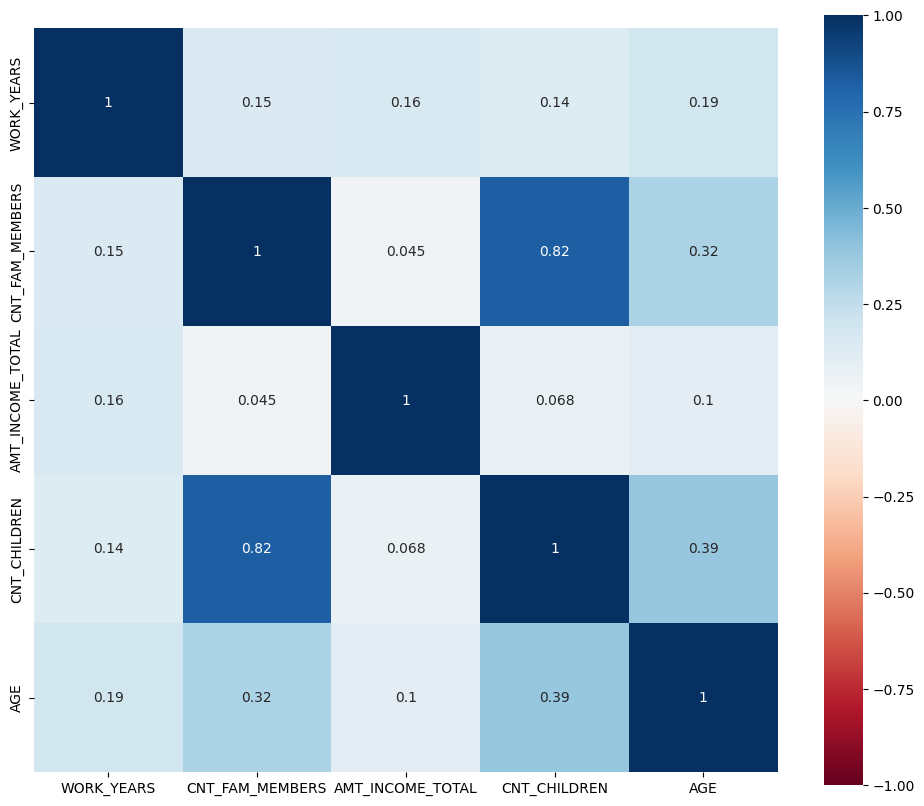

In [18]:
plt.figure(figsize=(12, 10))
sns.heatmap(df_OUTLIERS[num_names].corr(method='spearman').abs(),
            square=True,
            annot=True,
            cmap='RdBu',
            vmin=-1,
            vmax=1)
plt.show()

La única correlación alta, la de 'CNT_CHILDREN'-'CNT_FAM_MEMBERS' con 82.

In [19]:
fig = px.scatter(df_OUTLIERS,
                 x='CNT_CHILDREN',
                 y='CNT_FAM_MEMBERS')
fig.show()

Se toma la decisión de eliminar una de estas variables.

In [20]:
drop_names_by_corr = ['CNT_FAM_MEMBERS']

In [21]:
df_CORR = df_OUTLIERS.drop(drop_names_by_corr, axis=1)
num_names = [name for name in num_names if name not in drop_names_by_corr]
df_CORR.reset_index(drop=True, inplace=True)

In [22]:
num_names

['WORK_YEARS', 'AMT_INCOME_TOTAL', 'CNT_CHILDREN', 'AGE']

## 2.3 Comportamiento con respecto a la variable objetivo.

Veamos el comportamiento de las variables numéricas 'AGE', 'AMT_INCOME_TOTAL', 'CNT_CHILDREN' con respecto al 'STATUS'.

In [23]:
for name in list(set(num_names)-set(['WORK_YEARS'])):
    print(f'################################## VARIABLE: {name} ################################################')
    fig = px.violin(df_CORR,
                    y=name,
                    x='STATUS',
                    box=True)
    fig.show()
    # fig2 = px.histogram(df_CORR,
    #                     x=name,
    #                     color="STATUS",
    #                     opacity=0.6)
    # fig2.show()

################################## VARIABLE: CNT_CHILDREN ################################################


################################## VARIABLE: AGE ################################################


################################## VARIABLE: AMT_INCOME_TOTAL ################################################


Se observa lo siguiente:
1. Se nota un ligero desface en la distrubución de 'AGE' con respecto a 'STATUS'. Sugiere que los MALOS clientes son uno o dos años más jóvenes.
2. Para 'AMT_INCOME_TOTAL', en el lado de los BUENOS clientes, hay miembros que ganan anualmente más de 500000, algo que no sucede para los MALOS clientes. 
3. Para 'CNT_CHILDREN', hay algunos del lado de los BUENOS clientes que tienen más de 3 hijos y esto no se ve en los MALOS clientes. Hay una mayor concentración en el caso de los BUENOS clientes cercana al cero, por lo que se puede decir que ellos tienden a no tener hijos.

En cuanto a 'WORK_YEARS' se tiene lo siguiente. Se tiene la gráfica para el caso de esta variable para personas *empleadas*.

In [24]:
fig = px.violin(df_CORR[df_CORR['WORK_YEARS']>=0],
                y='WORK_YEARS',
                x='STATUS',
                box=True)
fig.show()

Es notoria una concentración en los primeros dos años de trabajo para los MALOS clientes. Sería natural pensar que una persona apenas va a entrar a un periodo de estabilización después de recien encontrar trabajo, por ejemplo.

Ahora, para las clientes *desempleados* se tiene lo siguiente.

In [25]:
df_unemployed = df_CORR[df_CORR['WORK_YEARS'] < 0]
print('% de personas desempleadas con respecto al total:',
      round(((df_unemployed.shape[0]/df_CORR.shape[0]) * 100), 2))

% de personas desempleadas con respecto al total: 15.5


Solo conforman el 15.5% de la data total. El % de morosos que cae en esta "categoría" es el siguiente:

In [26]:
count_objected = df_unemployed['STATUS'].value_counts().to_frame().reset_index()
count_objected.columns = ['STATUS', 'count']
count_objected['% con respecto al total'] = round((count_objected['count'] / df_CORR.shape[0]) * 100, 2)
count_objected

,STATUS,count,% con respecto al total
0,0,679,13.65
1,1,92,1.85


Con solo el 1.85 % de clientes *desempleados* que caen en mora, se puede ver que esta condición no es tan determinante para ser un cliente "MALO".

In [27]:
#df_CORR[df_CORR['WORK_YEARS']<0]['STATUS'].value_counts(normalize=True)

## 2.4 Eliminación de variables.

Ya tranformadas, las variables `DAYS_BIRTH`y `DAYS_EMPLOYED` se eliminan.

In [28]:
unwanted_names = ['DAYS_BIRTH', 'DAYS_EMPLOYED']
df_CORR = df_CORR.drop(unwanted_names, axis=1)
num_names = [name for name in num_names if name not in unwanted_names]

In [29]:
num_names

['WORK_YEARS', 'AMT_INCOME_TOTAL', 'CNT_CHILDREN', 'AGE']

# 3. TRATAMIENTO DE VARIABLES CATEGÓRICA.

## 3.1 Cambio de tipo de variables y tratamiento de valores perdidos.

Se determinan las variables categóricas. Para fines prácticos, las variables de naturaleza binaria también 
se considerarán categóricas.

In [30]:
flag_names = ['FLAG_MOBIL','FLAG_WORK_PHONE','FLAG_PHONE', 'FLAG_EMAIL']
cat_names = list(df_CORR.select_dtypes('object').columns) + flag_names
cat_names

['CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'FLAG_MOBIL',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'FLAG_EMAIL']

Las variables binarias será tratadas como tipo string como lo son el resto de variables categóricas.

In [31]:
binary_names = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_MOBIL', 
                'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL']
for name in binary_names:
    df_CORR[name] = df_CORR[name].astype(str)

Se toma la decisión de incluir una categoría que represente los valores perdidos en variables categóricas, más bien en'OCCUPATION_TYPE'. Esta categoría llevará el nombre de "Unidentified".

In [32]:
df_FILLNA_CATEGORIC = fillna_categoric_data(data=df_CORR,
                                            list_names=cat_names)

## 3.2 Fusión de categorías.

A continuación, se dará un vistazo a los tamaños clase en cada variable categórica, así como a su porcentaje de representación.

In [33]:
for name in cat_names:
    print(f'################# VARIABLE: {name} #########################################' )
    print('FRECUENCIA:')
    print(df_FILLNA_CATEGORIC[name].value_counts())
    print('FRECUENCIA RELATIVA:')
    print(round((df_FILLNA_CATEGORIC[name].value_counts(normalize=True)) * 100), 2)

################# VARIABLE: CODE_GENDER #########################################
FRECUENCIA:
F    3295
M    1680
Name: CODE_GENDER, dtype: int64
FRECUENCIA RELATIVA:
F    66.0
M    34.0
Name: CODE_GENDER, dtype: float64 2
################# VARIABLE: FLAG_OWN_CAR #########################################
FRECUENCIA:
N    2980
Y    1995
Name: FLAG_OWN_CAR, dtype: int64
FRECUENCIA RELATIVA:
N    60.0
Y    40.0
Name: FLAG_OWN_CAR, dtype: float64 2
################# VARIABLE: FLAG_OWN_REALTY #########################################
FRECUENCIA:
Y    3180
N    1795
Name: FLAG_OWN_REALTY, dtype: int64
FRECUENCIA RELATIVA:
Y    64.0
N    36.0
Name: FLAG_OWN_REALTY, dtype: float64 2
################# VARIABLE: NAME_INCOME_TYPE #########################################
FRECUENCIA:
Working                 2592
Commercial associate    1178
Pensioner                784
State servant            418
Student                    3
Name: NAME_INCOME_TYPE, dtype: int64
FRECUENCIA RELATIVA:
Working       

Se toma la decisión de fusionar categorías con frecuencia menor o igual a 1%. A continuación, se enlistan las funciones que se encargarán de estas fusiones. Originalmente, este dipo de funciones deben de ir en el script __EDA_fucntions.py__

In [34]:
def NAME_EDUCATION_TYPE_class(education_type):
    """
    Tiene como tarea homogeneizar los valores de la variable "NAME_EDUCATION_TYPE".
    """
    if education_type in ['Higher education', 'Academic degree']:
        return 'Higher education or Academic degree'
    elif education_type in ['Lower secondary', 'Incomplete higher']:
        return 'Lower secondary or Incomplete higher'
    else:
        return education_type
    

def NAME_HOUSING_TYPE_clas(housing_type):
    """
    Tiene como tarea homogeneizar los valores de la variable "NAME_HOUSING_TYPE".
    """
    if housing_type in ['Rented apartment', 'Office apartment', 'Co-op apartment']:
        return 'Rented apartment or Office apartment or Co-op apartment'
    else:
        return housing_type
        
def OCCUPATION_TYPE_class(occupation_type):
    """
    Tiene como tarea homogeneizar los valores de la variable "OCCUPATION_TYPE".
    """
    if occupation_type in ['Cleaning staff', 'Private service staff', 'Secretaries',
                           'Waiters/barmen staff', 'Low-skill Laborers', 'IT staff',
                           'Realty agents', 'HR staff']:
        return 'Others'
    else:
        return occupation_type

In [35]:
df_HOMO_CLASS = df_FILLNA_CATEGORIC.copy()

In [36]:
df_HOMO_CLASS['NAME_EDUCATION_TYPE'] = list(map(NAME_EDUCATION_TYPE_class,
                                                df_HOMO_CLASS['NAME_EDUCATION_TYPE']))
df_HOMO_CLASS['NAME_HOUSING_TYPE'] = list(map(NAME_HOUSING_TYPE_clas,
                                                df_HOMO_CLASS['NAME_HOUSING_TYPE']))
df_HOMO_CLASS['OCCUPATION_TYPE'] = list(map(OCCUPATION_TYPE_class,
                                                df_HOMO_CLASS['OCCUPATION_TYPE']))

Se da un check de las fusiones.

In [37]:
for name in cat_names:
    print(f'################# VARIABLE: {name} #########################################' )
    print('FRECUENCIA:')
    print(df_HOMO_CLASS[name].value_counts())
    print('FRECUENCIA RELATIVA:')
    print(round((df_HOMO_CLASS[name].value_counts(normalize=True))*100), 2)

################# VARIABLE: CODE_GENDER #########################################
FRECUENCIA:
F    3295
M    1680
Name: CODE_GENDER, dtype: int64
FRECUENCIA RELATIVA:
F    66.0
M    34.0
Name: CODE_GENDER, dtype: float64 2
################# VARIABLE: FLAG_OWN_CAR #########################################
FRECUENCIA:
N    2980
Y    1995
Name: FLAG_OWN_CAR, dtype: int64
FRECUENCIA RELATIVA:
N    60.0
Y    40.0
Name: FLAG_OWN_CAR, dtype: float64 2
################# VARIABLE: FLAG_OWN_REALTY #########################################
FRECUENCIA:
Y    3180
N    1795
Name: FLAG_OWN_REALTY, dtype: int64
FRECUENCIA RELATIVA:
Y    64.0
N    36.0
Name: FLAG_OWN_REALTY, dtype: float64 2
################# VARIABLE: NAME_INCOME_TYPE #########################################
FRECUENCIA:
Working                 2592
Commercial associate    1178
Pensioner                784
State servant            418
Student                    3
Name: NAME_INCOME_TYPE, dtype: int64
FRECUENCIA RELATIVA:
Working       

Se decide eliminar los 3 únicos miembros en la categoría de estudiantes en 'NAME_INCOME_TYPE'.

In [38]:
df_HOMO_CLASS = df_HOMO_CLASS[-df_HOMO_CLASS['NAME_INCOME_TYPE'].isin(['Student'])]

In [39]:
df_HOMO_CLASS.columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_MOBIL',
       'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'STATUS', 'AGE', 'WORK_YEARS'],
      dtype='object')

Quedará pendiente desarrollar visualizaciones para poder estudiar como se comportan las variables categóricas, con respecto a la variable `STATUS`.

## 3.4 Eliminación de variables

Se eliminará la variable de género `CODE_GENDER` para prevenir el sesgo del modelo e incurrir en discriminación.
Además, se eliminará la variable `FLAG_MOBIL` porque todos los clientes manifestaron tener teléfono movil.

In [40]:
unwanted_names = ['CODE_GENDER', 'FLAG_MOBIL']
df_HOMO_CLASS = df_HOMO_CLASS.drop(unwanted_names, axis=1)
cat_names = [name for name in cat_names if name not in unwanted_names]

In [41]:
df_HOMO_CLASS['STATUS'].value_counts(normalize=True)

0    0.899839
1    0.100161
Name: STATUS, dtype: float64

# 5. SELECCIÓN DE VARIABLES ANTES DE ENTRENAMIENTO

Aunque este no es el caso, ante un escenario con presencia de muchas variables numéricas o variables categóricas ordinales, uno puede hacer una selección de variables ANTES DE ENTRENAMIENTO usando la __información mutua__, la cual es una métrica traída de la Teoría de la Información. Este es un valor no negativo que mide la dependencia entre variables aleatorias. Valores más altos significan una dependencia más alta.

Análogamente, se puede estudiar la relación de las variables categóricas con el objetivo binario usando *pruebas chi-quadrada de independencia* que pueden aplicarse al hacer uso de tablas de contingencia.

En el caso de las variables numéricas, solo se dará un vistazo de cómo queda la __información mutua__ pero no se usará, en este ejercicio, para selección de variables. En realidad, para nuestro caso, se tienen muy pocas *features*, por lo que se usarán todas y se verá su importancia DESPUÉS DE ENTRENAMIENTO, usando las *features importances* proporcionadas por scikit-learn, o bien usando las *shap feature importances*.

In [42]:
mutual_information_score(data=df_HOMO_CLASS,
                         feature_names=num_names,
                         y_label_name='STATUS',
                         list_bool_True=None,
                         seed=seed)

,features,mutual_info
0,AMT_INCOME_TOTAL,0.008343
1,AGE,0.005414
2,WORK_YEARS,0.002575
3,CNT_CHILDREN,0.000225


Se sugiere que la variable 'AMT_INCOME_TOTAL' es la más importante. Se vará si esto está de acorde a las importancias después de entrenamiento.

# 7. LISTA FINAL DE FEATURES.

Se exihiben qué variables conformarán el conjunto definitivo de features. Están serán puestas en un archivo de configuración config.yaml para un manejo más flexible de algunos scripts, sobre todo en el script de predicción.

In [43]:
objective_name = 'STATUS'

In [44]:
num_names

['WORK_YEARS', 'AMT_INCOME_TOTAL', 'CNT_CHILDREN', 'AGE']

In [45]:
feature_names = cat_names + num_names
feature_names

['FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'WORK_YEARS',
 'AMT_INCOME_TOTAL',
 'CNT_CHILDREN',
 'AGE']

# 8. GUARDADO DE LA DATA.

Los conjuntos de datos de __Entrenamiento__ y __Testeo__ (más bien los dataframes) se guardarán en archivos binarios.

In [46]:
df_HOMO_CLASS

,ID,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,STATUS,AGE,WORK_YEARS
0,5009628,N,N,0,238500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,Laborers,1,52,9
1,5009746,Y,N,0,315000.0,Commercial associate,Higher education or Academic degree,Married,House / apartment,1,1,0,Unidentified,1,37,1
2,5009938,N,Y,2,157500.0,Working,Secondary / secondary special,Married,House / apartment,0,0,0,Sales staff,1,29,6
3,5010061,N,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,0,0,0,Unidentified,1,45,12
4,5010535,Y,N,2,135000.0,Working,Secondary / secondary special,Married,House / apartment,0,0,0,Laborers,1,38,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4970,5139370,N,Y,0,121500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,0,0,0,High skill tech staff,0,50,22
4971,5066551,N,Y,0,135000.0,Pensioner,Higher education or Academic degree,Married,House / apartment,0,1,1,Unidentified,0,64,-1000
4972,5036785,N,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,0,1,0,Others,0,43,0
4973,5088266,N,Y,0,270000.0,Working,Secondary / secondary special,Married,House / apartment,0,0,0,Unidentified,0,45,18


In [47]:
df_HOMO_CLASS.reset_index(drop=True, inplace=True)

In [48]:
# pickle.dump(df_HOMO_CLASS, open('../outputs/df_HOMO_CLASS.sav', 'wb'))